# ART HopSkipJump Attack

In [1]:
%matplotlib inline

import numpy as np
import keras
from keras.preprocessing import image
from keras.layers import Dense, Flatten
from keras.models import Model
import keras.backend as k
from matplotlib import pyplot as plt
from IPython.display import clear_output

Using TensorFlow backend.


In [2]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

## Lenet

In [3]:
import numpy as np
import cv2
import os

import keras
from keras.datasets import mnist
from keras.layers import Conv2D, Dense, AveragePooling2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras import backend as K

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
#os.environ['CUDA_VISIBLE_DEVICES']='2' #使用GPU

In [4]:
class LeNet5:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        model.add(Conv2D(6, kernel_size=(5,5),
                            padding="valid", activation="sigmoid", 
                            input_shape=inputShape ))
        model.add(AveragePooling2D(pool_size=(2,2)))
        model.add(Conv2D(16, kernel_size=(5,5), 
                            padding="valid", activation="sigmoid"))
        model.add(AveragePooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(120, activation="sigmoid"))
        model.add(Dense(84, activation="sigmoid"))
        model.add(Dense(10, activation="softmax"))

        return model

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000,28,28,1)
x_test = x_test.reshape(10000,28,28,1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_train=to_categorical(y_train,num_classes=10)
y_test=to_categorical(y_test,num_classes=10)

In [6]:
x_train_new = np.zeros((x_train.shape[0], 32, 32, 1))
for i in range (0, x_train.shape[0]):
    x_train_new[i] = np.pad(x_train[i].reshape(28, 28), [(2, ), (2, )], mode='constant').reshape(32, 32, 1)
x_train = x_train_new

In [7]:
x_test_new = np.zeros((x_test.shape[0], 32, 32, 1))
for i in range (0, x_test.shape[0]):
    x_test_new[i] = np.pad(x_test[i].reshape(28, 28), [(2, ), (2, )], mode='constant').reshape(32, 32, 1)
x_test = x_test_new

In [8]:
model = LeNet5.build(32, 32, 1, 10)
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=5e-4), metrics=["accuracy"])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               48120     
______________________________________

In [135]:
model.fit(x_train,y_train,batch_size=120,epochs=7)

Epoch 1/7
60000/60000 [==============================] - 29s 484us/step - loss: 0.0969 - accuracy: 0.9714
Epoch 2/7
60000/60000 [==============================] - 28s 469us/step - loss: 0.0866 - accuracy: 0.9744
Epoch 3/7
60000/60000 [==============================] - 28s 465us/step - loss: 0.0797 - accuracy: 0.9762
Epoch 4/7
60000/60000 [==============================] - 29s 485us/step - loss: 0.0738 - accuracy: 0.9779s - loss: 0.074
Epoch 5/7
60000/60000 [==============================] - 28s 471us/step - loss: 0.0685 - accuracy: 0.9792
Epoch 6/7
60000/60000 [==============================] - 29s 484us/step - loss: 0.0645 - accuracy: 0.9808
Epoch 7/7
60000/60000 [==============================] - 29s 483us/step - loss: 0.0605 - accuracy: 0.9819


In [136]:
for i in [0, 2, 5, 6, 7]:
    x = model.layers[i].get_weights()[0] #weights
    y = model.layers[i].get_weights()[1] #array of biases
    y = np.zeros(y.shape)
    l=[]
    l.append(x)
    l.append(y)
    model.layers[i].set_weights(l)

In [137]:
model.save('lenet.h5')

In [9]:
from keras.models import load_model
model = load_model('lenet.h5')

# Model Definition

In [139]:
classifier = KerasClassifier(clip_values=(0, 255), model=model)

# Get Target and Init Images

In [140]:
init_image = x_test[2].reshape(1, 32, 32, 1)

Init image is:  1


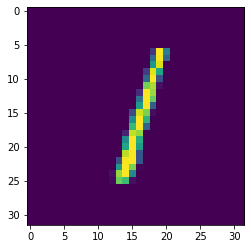

In [141]:
print( "Init image is: ", np.argmax(classifier.predict(init_image)) )
plt.imshow(init_image.reshape(32, 32).astype(np.uint))
plt.show()

In [142]:
target_image = x_test[0].reshape(1, 32, 32, 1)

Target image is:  7


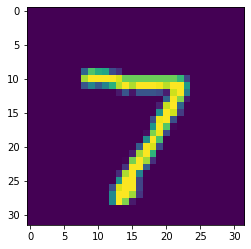

In [143]:
print( "Target image is: ", np.argmax(classifier.predict(target_image)) )
plt.imshow(target_image.reshape(32, 32).astype(np.uint))
plt.show()

In [144]:
from PIL import Image

Target image is:  5


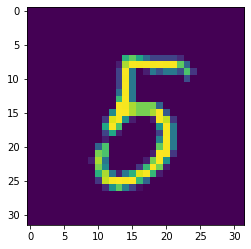

In [145]:
test_image = x_test[45].reshape(1, 32, 32, 1)
print( "Target image is: ", np.argmax(classifier.predict(test_image)) )
# Image.fromarray(test_image).save("test.bmp")
plt.imshow(test_image.reshape(32, 32).astype(np.uint))
plt.show()

In [146]:
Image.fromarray(test_image.reshape(32, 32).astype(np.uint8)).save('test.bmp', 'bmp')

In [147]:
y_pred = np.argmax(classifier.predict(x_test), axis=1)
y_tests = np.argmax(y_test, axis=1)

In [148]:
accuracy_score(y_tests, y_pred)

0.9834

# HopSkipJump Untargeted Attack

In [149]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = None
for i in range(20):
    x_adv = attack.generate(x=init_image, x_adv_init=x_adv, resume=True)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
#     plt.imshow(x_adv[0].reshape(32, 32).astype(np.uint))
#     plt.show(block=False)
    
    attack.max_iter = iter_step

HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 0. L2 error 2165.3489367348247 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 10. L2 error 2170.8460915449186 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 20. L2 error 2172.258345999295 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 30. L2 error 2173.0998812752305 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 40. L2 error 2173.023054445422 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 50. L2 error 2173.3328318537947 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 60. L2 error 2173.463363686383 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 70. L2 error 2173.775646141353 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 80. L2 error 2173.9906265446543 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 90. L2 error 2173.9628445554476 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 100. L2 error 2174.131228420442 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 110. L2 error 2174.125810107895 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 120. L2 error 2174.0173464798277 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 130. L2 error 2173.7453776315924 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 140. L2 error 2173.728420282192 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 150. L2 error 2173.7537032644586 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 160. L2 error 2173.6512091725767 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 170. L2 error 2173.7422671749614 and class label 8.


HopSkipJump:   0%|                                       | 0/1 [00:00<?, ?it/s]

Adversarial image at step 180. L2 error 2173.753288766964 and class label 8.


HopSkipJump: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.27s/it]

Adversarial image at step 190. L2 error 2173.653647215007 and class label 8.


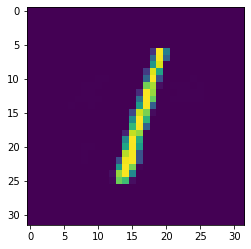

In [150]:
plt.imshow(x_adv[0].reshape(32, 32).astype(np.uint))

In [151]:
np.argmax(classifier.predict(x_adv)[0])

8

# HopSkipJump Targeted Attack

HopSkipJump: 100%|█████████████████████████████| 1/1 [00:00<00:00, 1000.07it/s]


Adversarial image at step 0. L2 error 2176.560819274297 and class label 1.


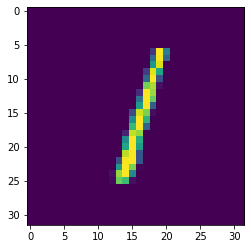

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


Adversarial image at step 10. L2 error 1904.1299146998304 and class label 1.


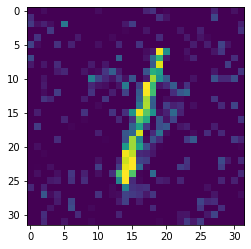

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Adversarial image at step 20. L2 error 1858.6605661765902 and class label 1.


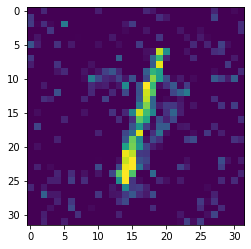

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:00<00:00,  1.01it/s]


Adversarial image at step 30. L2 error 1821.6671722904593 and class label 1.


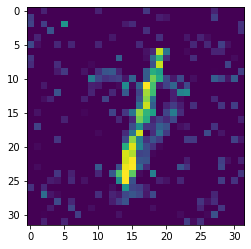

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.15s/it]


Adversarial image at step 40. L2 error 1785.711565442625 and class label 1.


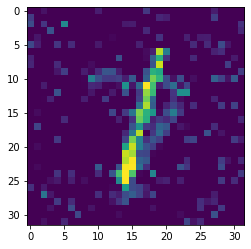

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.29s/it]


Adversarial image at step 50. L2 error 1743.8862180167546 and class label 1.


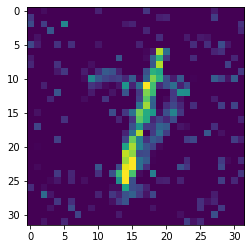

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.39s/it]


Adversarial image at step 60. L2 error 1714.6525731341899 and class label 1.


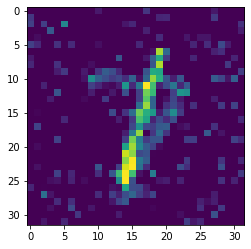

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.46s/it]


Adversarial image at step 70. L2 error 1706.3075397923087 and class label 1.


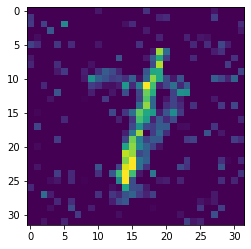

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.51s/it]


Adversarial image at step 80. L2 error 1686.3168528925119 and class label 1.


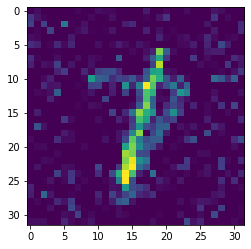

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.60s/it]


Adversarial image at step 90. L2 error 1653.400458568536 and class label 1.


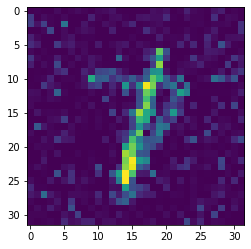

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.64s/it]


Adversarial image at step 100. L2 error 1562.9733590967492 and class label 1.


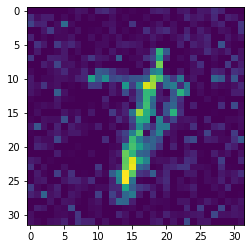

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.71s/it]


Adversarial image at step 110. L2 error 1443.8417581232238 and class label 1.


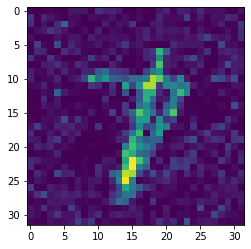

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.01s/it]


Adversarial image at step 120. L2 error 1071.3182126731172 and class label 1.


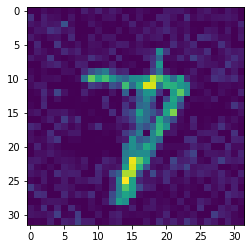

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.83s/it]


Adversarial image at step 130. L2 error 847.3664486295272 and class label 1.


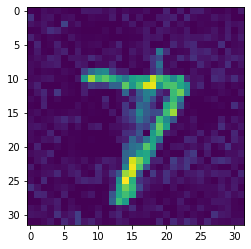

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.94s/it]


Adversarial image at step 140. L2 error 738.172442422698 and class label 1.


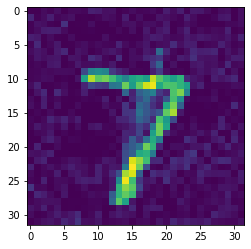

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:01<00:00,  1.97s/it]


Adversarial image at step 150. L2 error 580.3121522380045 and class label 1.


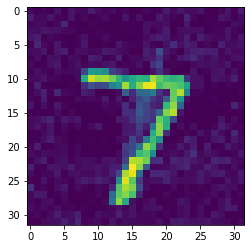

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.03s/it]


Adversarial image at step 160. L2 error 539.4081437617473 and class label 1.


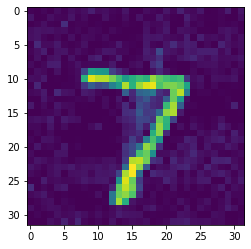

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.09s/it]


Adversarial image at step 170. L2 error 472.57442748779346 and class label 1.


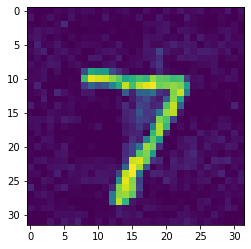

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.16s/it]


Adversarial image at step 180. L2 error 430.89108129234836 and class label 1.


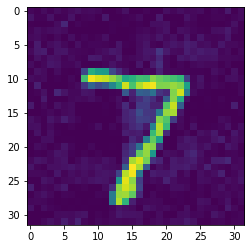

HopSkipJump: 100%|███████████████████████████████| 1/1 [00:02<00:00,  2.20s/it]


Adversarial image at step 190. L2 error 393.02150537965605 and class label 1.


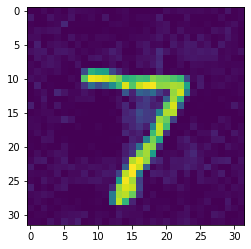

In [152]:
attack = HopSkipJump(classifier=classifier, targeted=True, max_iter=0, max_eval=1000, init_eval=10)
iter_step = 10
x_adv = init_image
for i in range(20):
    x_adv = attack.generate(x=target_image, y=to_categorical([1], 1000), x_adv_init=x_adv, resume=True)

    #clear_output()
    print("Adversarial image at step %d." % (i * iter_step), "L2 error", 
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0].reshape(32, 32).astype(np.uint))
    plt.show(block=False)
    
    attack.max_iter = iter_step

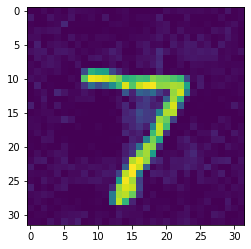

In [153]:
plt.imshow(x_adv[0].reshape(32, 32).astype(np.uint))

In [154]:
np.argmax(classifier.predict(x_adv.astype(np.uint).astype(np.float32))[0])

1

In [70]:
np.set_printoptions(suppress=True)